# Leaf Disease Segmenation using U-Net

# Import

In [14]:
import os
import numpy as np
import pandas as pd
import random
import shutil
import matplotlib.pyplot as plt

from PIL import Image
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

import cv2
from mpl_toolkits.mplot3d import Axes3D

# Data preparation

In [4]:
image_source_dir = "E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/aug_data/images"
mask_source_dir = "E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/aug_data/masks"

# Create directories for training and testing images and masks
train_image_dir = "E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/train_image"
train_mask_dir = "E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/train_mask"
test_image_dir = "E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/test_image"

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

# List all image and masl files
image_files = os.listdir(image_source_dir)
mask_file = os.listdir(mask_source_dir)

validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files) - num_validation_samples

# Shuffle the image files
random.shuffle(image_files)

# Move files to train and val directories
for i, image_file in enumerate(image_files):
    source_image_path = os.path.join(image_source_dir, image_file)
    source_mask_file = os.path.splitext(image_file)[0] + ".png"
    source_mask_path = os.path.join(mask_source_dir, source_mask_file)
    shutil.copy(source_image_path, os.path.join(train_image_dir, image_file))
    shutil.copy(source_mask_path, os.path.join(train_mask_dir, source_mask_file))

random.shuffle(image_files)

for i, image_file in enumerate(image_files):
    source_image_path = os.path.join(image_source_dir, image_file)
    shutil.copy(source_image_path, os.path.join(test_image_dir, image_file))

print("Done!")

Done!


# Visualizing data

image pathL E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/train_image\00453_4.jpg
image size: (256, 256)
type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


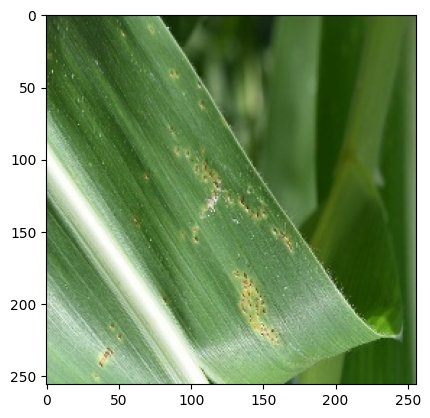

mask path: E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/train_mask\00453_4.png
mask size: (256, 256)


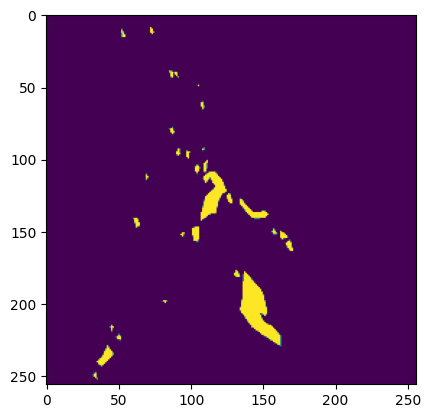

---


In [6]:
def show_images(loops=1):
    for i in range(loops):
        image_path = os.path.join(train_image_dir, image_files[i])
        source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
        mask_path = os.path.join(train_mask_dir, source_mask_file)
        img = Image.open(image_path)
        mask = Image.open(mask_path)

        print(f"image pathL {image_path}")
        print(f"image size: {img.size}")
        print(f"type: {type(img)}")

        plt.imshow(img)
        plt.show()

        print(f"mask path: {mask_path}")
        print(f"mask size: {mask.size}")
        plt.imshow(mask)
        plt.show()

        print("---")

show_images(loops=1)

# Resize image and mask

In [12]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')
for i in tqdm(range(num_train_samples), desc='Processing images'):
    img_path = os.path.join(train_image_dir, image_files[i])
    source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
    mask_path = os.path.join(train_mask_dir, source_mask_file)
    
    img = Image.open(img_path)
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img
    
    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[i] = mask

    
X_test = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images') 
for i in tqdm(range(num_validation_samples), desc='Processing images'):
    img_path = os.path.join(test_image_dir, image_files[i])
    img = Image.open(img_path)
    img = np.array(img)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

Resizing training images and masks


Processing images: 100%|██████████| 2352/2352 [06:45<00:00,  5.81it/s]


Resizing test images


Processing images: 100%|██████████| 588/588 [01:27<00:00,  6.69it/s]


C:\Users\NGOVANUC\AppData\Local\Temp\ipykernel_12056\1571166455.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[image_x])


(128, 128, 3)


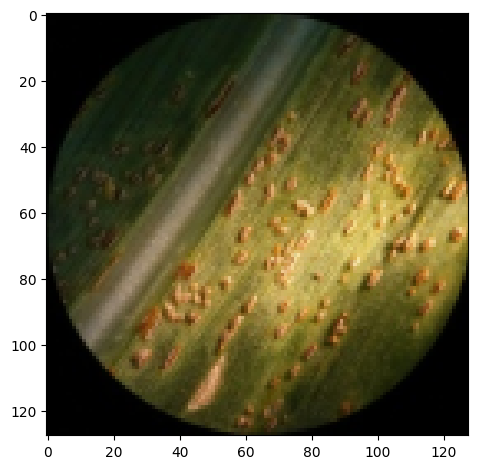

(128, 128, 1)


C:\Users\NGOVANUC\AppData\Local\Temp\ipykernel_12056\1571166455.py:6: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[image_x]))


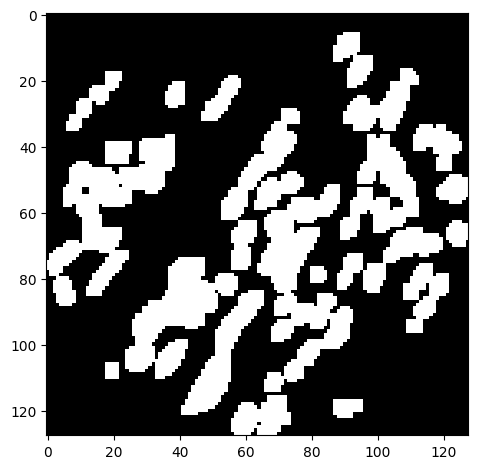

In [13]:
image_x = 4
imshow(X_train[image_x])
print(X_train[image_x].shape)
plt.show()

imshow(np.squeeze(Y_train[image_x]))
print(Y_train[image_x].shape)
plt.show()

# U-net model

In [20]:
# Build model
inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = keras.layers.Lambda(lambda x: x/255)(inputs)

# Contractiong path
c1 = Conv2D(13, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expanding path
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = keras.layers.concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = keras.layers.concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(13, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │        364 │ lambda_4[0][0]    │
│                     │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_15[0][0]   │
│                     │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      1,888 │ dropout_6[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_7[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_8[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_9[0][0] 

 Total params: 1,940,151 (7.40 MB)

 Trainable params: 1,940,151 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
checkpointer = keras.callbacks.ModelCheckpoint('Leaf_segmentation_using_U-net.h5', verbose=1, save_best_only=True)
callbacks = [
    keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir='logs')
]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 51s 375ms/step - accuracy: 0.9548 - loss: 0.1101 - val_accuracy: 0.9149 - val_loss: 0.2578
Epoch 2/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 51s 385ms/step - accuracy: 0.9560 - loss: 0.1080 - val_accuracy: 0.9146 - val_loss: 0.2692
Epoch 3/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 54s 407ms/step - accuracy: 0.9575 - loss: 0.1038 - val_accuracy: 0.9138 - val_loss: 0.2437
Epoch 4/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 58s 436ms/step - accuracy: 0.9570 - loss: 0.1045 - val_accuracy: 0.9133 - val_loss: 0.2737
Epoch 5/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.9590 - loss: 0.0997 - val_accuracy: 0.9152 - val_loss: 0.2576


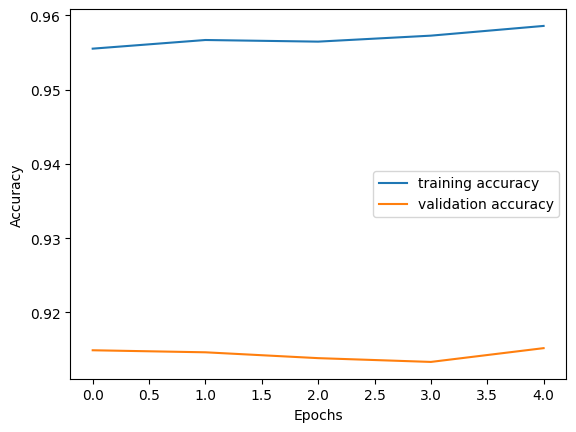

Final training accuracy: 0.9586


In [27]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
unetacc = history.history['accuracy'][-1]
print(f"Final training accuracy: {unetacc:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step


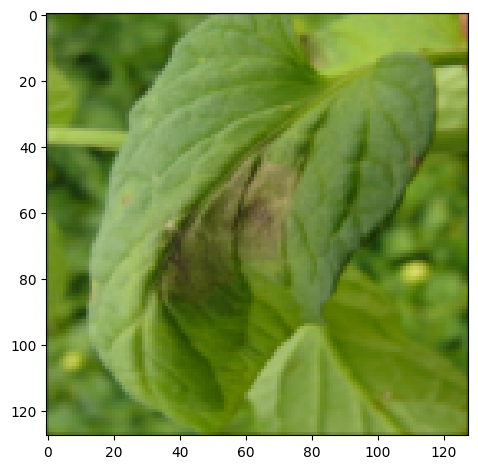

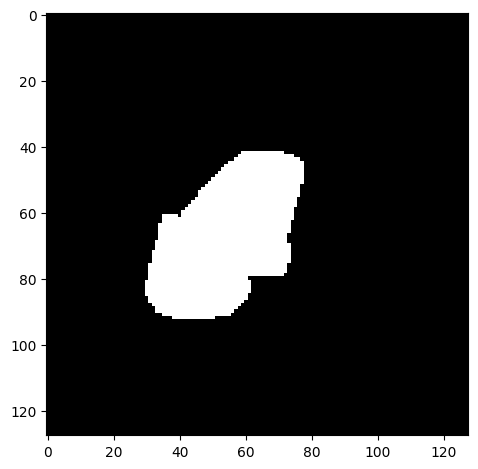

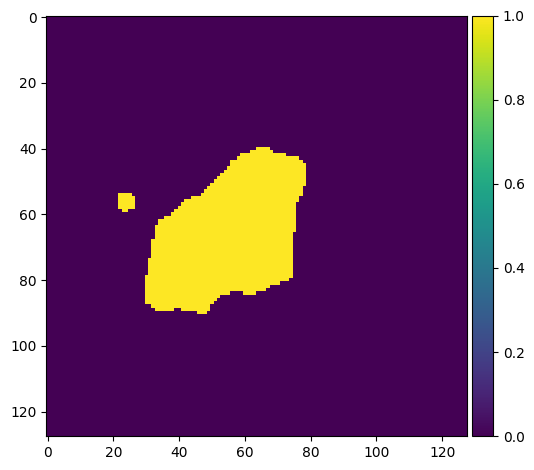

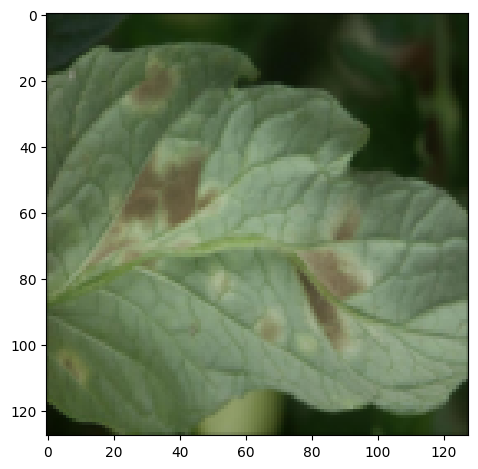

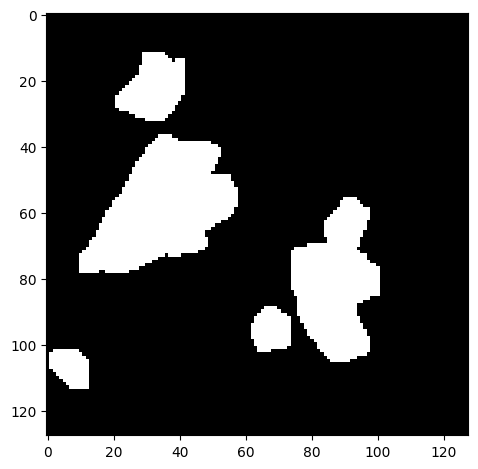

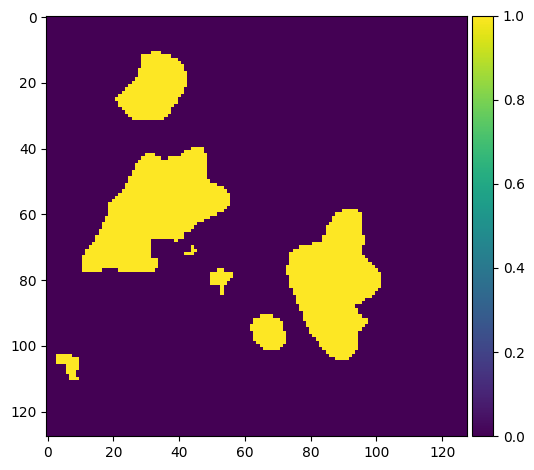

In [28]:
idx = 5

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a santity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()

imshow(np.squeeze(Y_train[ix]))
plt.show()

imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Save model

In [30]:
model.save('Leaf_segmentation_using_U-net.h5')
model.save('Leaf_segmentation_using_U-net.keras')

# Traning result

In [31]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

unetacc = train_acc

print(f"Precisión final de entrenamiento: {train_acc:.4f}")
print(f"Precisión final de validación: {val_acc:.4f}")

Precisión final de entrenamiento: 0.9586
Precisión final de validación: 0.9152


# Custom Model

Epoch 1/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 64s 439ms/step - accuracy: 0.9574 - loss: 0.1035 - val_accuracy: 0.9153 - val_loss: 0.2698
Epoch 2/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 69s 518ms/step - accuracy: 0.9565 - loss: 0.1058 - val_accuracy: 0.9091 - val_loss: 0.2510
Epoch 3/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 64s 481ms/step - accuracy: 0.9574 - loss: 0.1036 - val_accuracy: 0.9142 - val_loss: 0.2590
Epoch 4/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 57s 427ms/step - accuracy: 0.9557 - loss: 0.1080 - val_accuracy: 0.9129 - val_loss: 0.2638


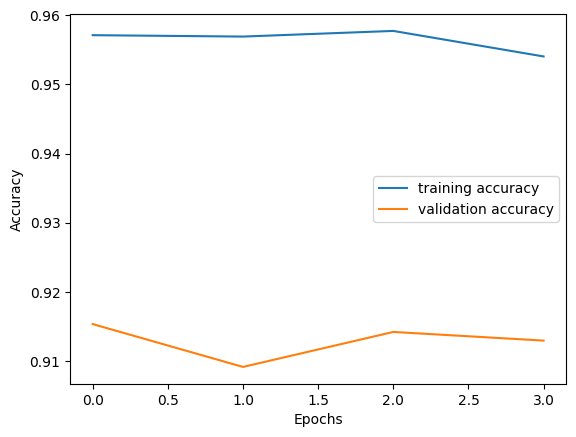

In [32]:
model = Sequential()

# Encoder
model.add(Conv2D(32, (3, 3), activation='leaky_relu', padding='same', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='leaky_relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

my_model = history.history['accuracy'][-1]

67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step


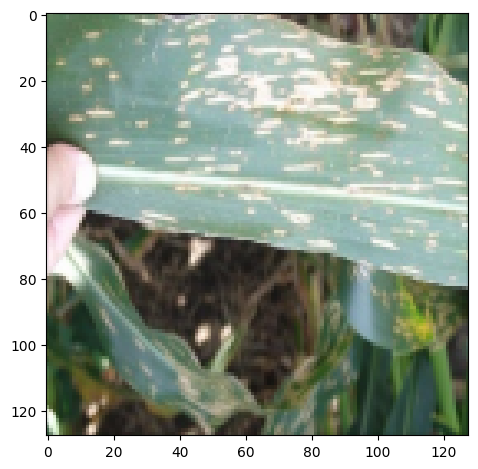

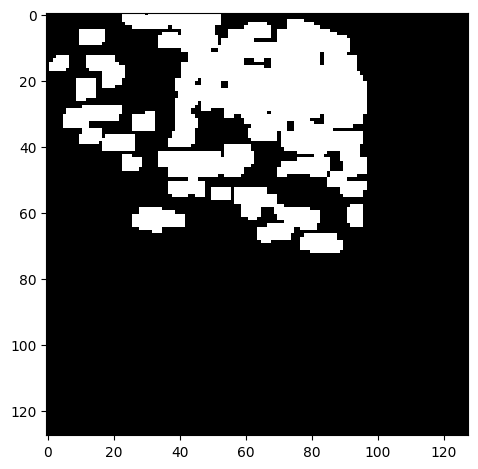

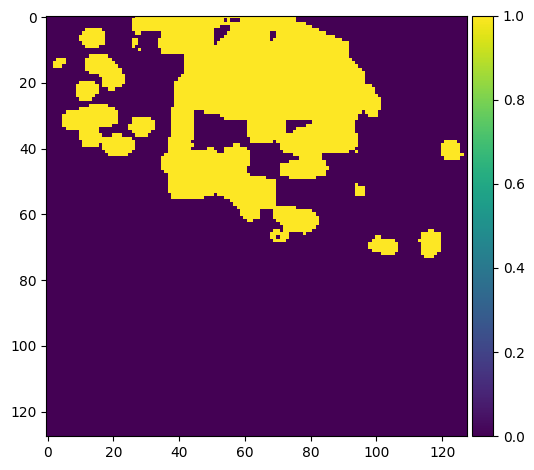

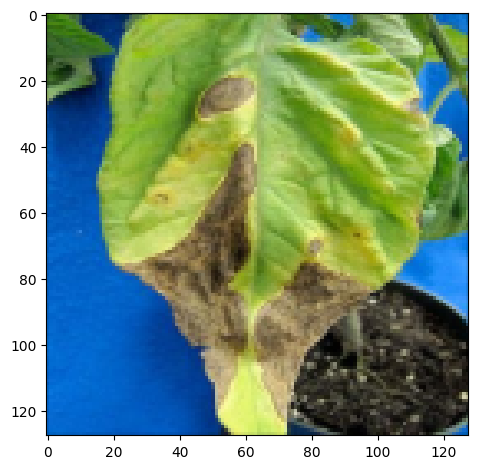

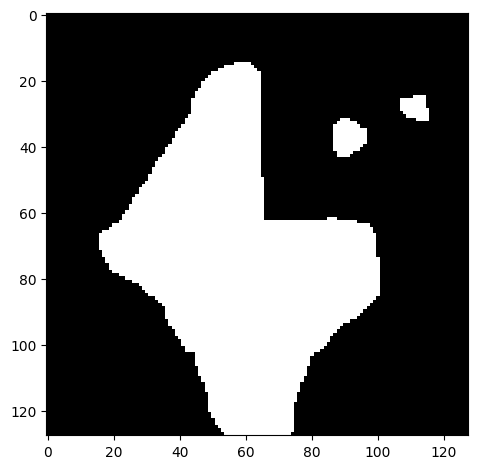

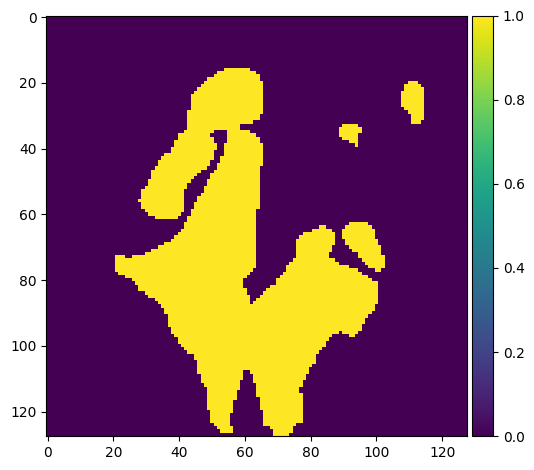

In [33]:
idx = 7

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()

imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()

imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# K-Means Clustering

In [34]:
img = cv2.imread("E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/aug_data/images/00000_0.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()#plotting 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

<Figure size 640x480 with 0 Axes>

In [35]:
original_image = cv2.imread("E:/IAD/researching/AI_application_in_agriculture/datasets/leaf_disease_segmentation_dataset/aug_data/images/00000_0.jpg")
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [36]:
K = 2
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2GRAY) 
result_image = cv2.bitwise_not(result_image)

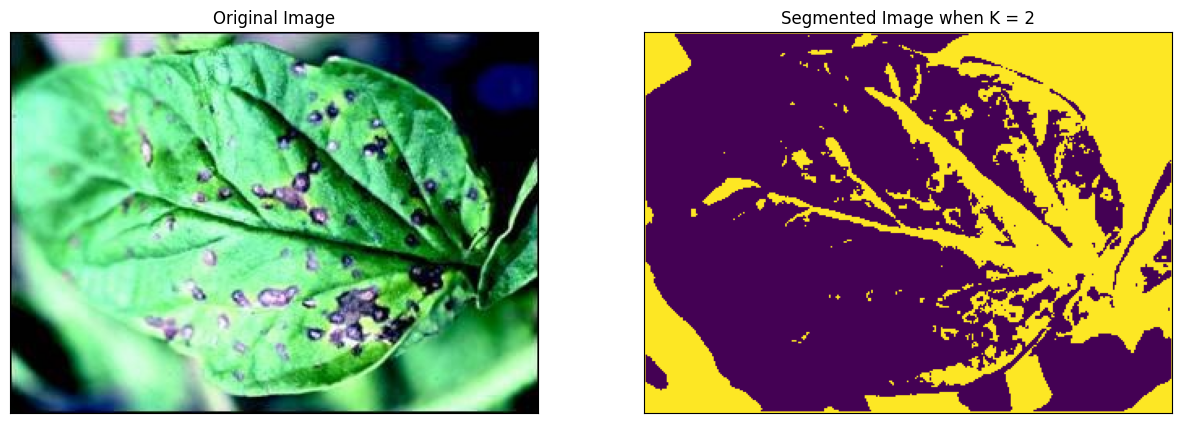

In [37]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()